In [1]:
from pandas import DataFrame
from MyModule import Vocab, load_vocab, load_data

train_seg = load_data('train_segmented.txt', sep='<sp>', is_segmented=True)
val_seg = load_data('val_segmented.txt', sep='<sp>', is_segmented=True)
test_seg = load_data('test_segmented.txt', sep='<sp>', is_segmented=True)

train_idx = load_data('train_indexed.txt', sep=',', is_indexed=True)
val_idx = load_data('val_indexed.txt', sep=',', is_indexed=True)
test_idx = load_data('test_indexed.txt', sep=',', is_indexed=True)

vocab = load_vocab('vocab.txt')

e:\anaconda3\envs\nlpllma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 通用训练、验证和测试框架
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn

def train_model_with_validation(  #@save
        model, 
        train_loader, 
        val_loader, 
        optimizer, 
        criterion=nn.CrossEntropyLoss(), 
        num_epochs=10, 
        device=torch.device('cuda'), 
        target_names=['Negative', 'Neutral', 'Positive']
        ):
    """
    通用的模型训练函数，支持验证集评估
    
    Args:
        model: PyTorch模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器 (可选)
        criterion: 损失函数
        optimizer: 优化器
        num_epochs: 训练轮数
        device: 设备 (cpu/cuda)
        target_names: 类别名称列表
        
    Returns:
        dict: 包含训练历史的字典
    """
    
    # 训练历史记录
    history = {
        'train_losses': [],
        'train_accuracies': [],
        'val_losses': [],
        'val_accuracies': [],
        'val_f1_scores': [],
        'val_precision_scores': [],
        'val_recall_scores': []
    }
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            # 处理不同模型的输入格式
            if len(batch) == 2:  # CNN
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model(inputs)
            elif len(batch) == 3:  # MLP, LSTM and Transformer
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    logits = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    logits = model(inputs, lengths)
            
            loss = criterion(logits, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            preds = logits.argmax(dim=1)
            train_correct += (preds == targets).sum().item()
            train_total += targets.size(0)
        
        # 记录训练指标
        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = train_correct / train_total
        history['train_losses'].append(avg_train_loss)
        history['train_accuracies'].append(train_acc)
        
        # 验证阶段
        if val_loader is not None:
            val_metrics = evaluate_model(model, val_loader, criterion, device)
            history['val_losses'].append(val_metrics['loss'])
            history['val_accuracies'].append(val_metrics['accuracy'])
            history['val_f1_scores'].append(val_metrics['f1'])
            history['val_precision_scores'].append(val_metrics['precision'])
            history['val_recall_scores'].append(val_metrics['recall'])
            
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train Loss: {avg_train_loss:.4f}\tTrain Accuracy: {train_acc:.4f}")
            print(f"    Valid Loss: {val_metrics['loss']:.4f}\tValid Accuracy: {val_metrics['accuracy']:.4f}")
            print(f"    Valid Precision: {val_metrics['precision']:.4f}\tValid Recall: {val_metrics['recall']:.4f}\tValid F1: {val_metrics['f1']:.4f}")
            print('-' * 80)
            
            # 最后一个epoch打印详细报告
            if epoch == num_epochs - 1:
                print("\nDetailed Classification Report:")
                print(classification_report(val_metrics['true_labels'], val_metrics['pred_labels'], 
                                          target_names=target_names, digits=4))
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f} - Accuracy: {train_acc:.4f}")
    
    return history

def evaluate_model(  #@save
        model, 
        data_loader, 
        criterion=nn.CrossEntropyLoss(), 
        device=torch.device('cuda')
        ):
    """
    通用的模型评估函数
    
    Args:
        model: PyTorch模型
        data_loader: 数据加载器
        criterion: 损失函数
        device: 设备
        
    Returns:
        dict: 评估结果字典
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in data_loader:
            # 处理不同模型的输入格式
            if len(batch) == 2:  # CNN, basic models
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model(inputs)
            elif len(batch) == 3:  # MLP, LSTM, Transformer
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    logits = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    logits = model(inputs, lengths)
            
            loss = criterion(logits, targets)
            total_loss += loss.item()
            
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    accuracy = correct / total
    avg_loss = total_loss / len(data_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_labels': all_targets,
        'pred_labels': all_preds
    }

def test_model_comprehensive(  #@save
        model, 
        model_name, 
        test_loader, 
        device=torch.device('cuda'), 
        target_names=['Negative', 'Neutral', 'Positive']
        ):
    """
    全面的模型测试函数，包含F1分数和混淆矩阵
    
    Args:
        model: PyTorch模型
        model_name: 模型名称
        test_loader: 测试数据加载器
        device: 设备
        target_names: 类别名称列表
        
    Returns:
        dict: 测试结果字典
    """
    model.eval()
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # 处理不同模型的输入格式
            if len(batch) == 2:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
            elif len(batch) == 3:
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    outputs = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs, lengths)
            
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    test_accuracy = correct / total
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    # 计算每个类别的指标
    class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
        all_targets, all_preds, average=None, zero_division=0
    )
    
    # 输出结果
    print("\n" + "="*80)
    print("TEST RESULTS")
    print("="*80)
    print(f"Model Name: {model_name}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision (weighted): {test_precision:.4f}")
    print(f"Test Recall (weighted): {test_recall:.4f}")
    print(f"Test F1 Score (weighted): {test_f1:.4f}")
    
    # 详细分类报告
    print("\nDetailed Test Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=target_names, digits=4))
    
    # 绘制混淆矩阵
    plot_confusion_matrix(model_name, all_targets, all_preds, target_names)

    # 打印每个类别的指标
    print("\nPer-Class Metrics:")
    print("-" * 60)
    for i, class_name in enumerate(target_names):
        print(f"{class_name:>8}: Precision={class_precision[i]:.4f}, "
              f"Recall={class_recall[i]:.4f}, F1={class_f1[i]:.4f}, "
              f"Support={int(class_support[i])}")
    
    return {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'class_metrics': {
            'precision': class_precision,
            'recall': class_recall,
            'f1': class_f1,
            'support': class_support
        }
    }

def plot_confusion_matrix(model_name, true_labels, pred_labels, target_names):  #@save
    """绘制规范化混淆矩阵"""
    plt.figure(figsize=(8, 6))
    
    cm = confusion_matrix(true_labels, pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names,
                cbar_kws={'label': 'Proportion'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    plt.tight_layout()
    plt.show()

def plot_training_curves(model_name, history, save_path=None):  #@save
    """绘制训练曲线"""
    num_epochs = len(history['train_losses'])
    
    plt.figure(figsize=(15, 5))
    
    # 训练损失和准确率
    plt.subplot(1, 2, 1)
    epochs_range = range(1, num_epochs+1)
    plt.plot(epochs_range, history['train_losses'], 'b--', label='Train Loss', linewidth=2)
    plt.plot(epochs_range, history['train_accuracies'], 'r-', label='Train Acc', linewidth=2)
    if history['val_accuracies']:
        plt.plot(epochs_range, history['val_accuracies'], 'g-', label='Val Acc', linewidth=2)
    
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'Training Loss & Accuracy - {model_name}')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.1)
    
    # 设置x轴刻度为整数
    plt.xticks(epochs_range)
    
    # 过拟合监控
    if history['val_accuracies']:
        plt.subplot(1, 2, 2)
        acc_diff = [train_acc - val_acc for train_acc, val_acc in 
                   zip(history['train_accuracies'], history['val_accuracies'])]
        plt.plot(epochs_range, acc_diff, 'purple', label='Train - Val Accuracy', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy Difference')
        plt.title(f'Overfitting Monitor - {model_name}')
        plt.ylim(-0.2, 0.5)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        
        # 设置x轴刻度为整数
        plt.xticks(epochs_range)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def print_training_summary(model_name, history):  #@save
    """打印训练摘要"""
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Model Name: {model_name}")
    print(f"Final Train Loss: {history['train_losses'][-1]:.4f}")
    print(f"Final Train Accuracy: {history['train_accuracies'][-1]:.4f}")
    
    if history['val_accuracies']:
        print(f"Final Val Loss: {history['val_losses'][-1]:.4f}")
        print(f"Final Val Accuracy: {history['val_accuracies'][-1]:.4f}")
        print(f"Best Val Accuracy: {max(history['val_accuracies']):.4f} (Epoch {history['val_accuracies'].index(max(history['val_accuracies']))+1})")
        print(f"Final Overfitting Gap: {history['train_accuracies'][-1] - history['val_accuracies'][-1]:.4f}")

### TF-IDF + 逻辑回归

In [3]:
# TF-IDF 特征化并构建 PyTorch Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame, Series


train_texts = [' '.join(tokens) for tokens in train_seg[0]]
val_texts = [' '.join(tokens) for tokens in val_seg[0]]
test_texts = [' '.join(tokens) for tokens in test_seg[0]]

train_labels = train_seg[1]
val_labels = val_seg[1]
test_labels = test_seg[1]

max_features = 50000

# 使用 TF-IDF 向量化（限制特征数以控制内存）
vectorizer = TfidfVectorizer(max_features=max_features, tokenizer=lambda x: x.split())
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

# 将稀疏矩阵包装为 Dataset
class SparseTfidfDataset(Dataset):
    def __init__(self, X: sparse.spmatrix, y: Series):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        row = self.X.getrow(idx).toarray().squeeze(0)  # 转为稠密向量（内存可控时使用）
        return torch.from_numpy(row).float(), torch.tensor(self.y[idx], dtype=torch.long)

# 使用 PyTorch 实现的 Logistic Regression
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, num_class):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, num_class)
    def forward(self, x):
        return self.linear(x)

e:\anaconda3\envs\nlpllma\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [4]:
num_class = 3
batch_size = 32
num_epoch = 10
input_dim = max_features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset_tfidf = SparseTfidfDataset(X_train, train_seg[1])
val_dataset_tfidf = SparseTfidfDataset(X_val, val_seg[1])
test_dataset_tfidf = SparseTfidfDataset(X_test, test_seg[1])

train_data_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=batch_size, shuffle=True)
val_data_loader_tfidf = DataLoader(val_dataset_tfidf, batch_size=batch_size, shuffle=False)
test_data_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=1, shuffle=False)

# 初始化模型、优化器与损失函数
logreg = LogisticRegression(input_dim, num_class).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(logreg.parameters(), lr=0.001)

In [5]:
logreg_history = train_model_with_validation(
    model=logreg,
    train_loader=train_data_loader_tfidf,
    val_loader=val_data_loader_tfidf,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epoch,
    device=device
    )

Training Epoch 1: 100%|██████████| 7844/7844 [01:16<00:00, 102.95it/s]


Epoch 1/10
    Train Loss: 0.8128	Train Accuracy: 0.6559
    Valid Loss: 0.7095	Valid Accuracy: 0.7040
    Valid Precision: 0.7048	Valid Recall: 0.7040	Valid F1: 0.6687
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7844/7844 [01:21<00:00, 96.42it/s] 


Epoch 2/10
    Train Loss: 0.6603	Train Accuracy: 0.7333
    Valid Loss: 0.6511	Valid Accuracy: 0.7325
    Valid Precision: 0.7227	Valid Recall: 0.7325	Valid F1: 0.7152
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7844/7844 [01:20<00:00, 97.35it/s] 


Epoch 3/10
    Train Loss: 0.6079	Train Accuracy: 0.7595
    Valid Loss: 0.6266	Valid Accuracy: 0.7399
    Valid Precision: 0.7298	Valid Recall: 0.7399	Valid F1: 0.7290
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7844/7844 [01:19<00:00, 99.22it/s] 


Epoch 4/10
    Train Loss: 0.5775	Train Accuracy: 0.7718
    Valid Loss: 0.6135	Valid Accuracy: 0.7442
    Valid Precision: 0.7342	Valid Recall: 0.7442	Valid F1: 0.7346
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7844/7844 [01:22<00:00, 95.26it/s] 


Epoch 5/10
    Train Loss: 0.5565	Train Accuracy: 0.7802
    Valid Loss: 0.6060	Valid Accuracy: 0.7470
    Valid Precision: 0.7375	Valid Recall: 0.7470	Valid F1: 0.7386
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 7844/7844 [01:17<00:00, 100.63it/s]


Epoch 6/10
    Train Loss: 0.5407	Train Accuracy: 0.7866
    Valid Loss: 0.6022	Valid Accuracy: 0.7468
    Valid Precision: 0.7368	Valid Recall: 0.7468	Valid F1: 0.7377
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 7844/7844 [01:23<00:00, 94.04it/s] 


Epoch 7/10
    Train Loss: 0.5281	Train Accuracy: 0.7916
    Valid Loss: 0.5999	Valid Accuracy: 0.7473
    Valid Precision: 0.7380	Valid Recall: 0.7473	Valid F1: 0.7397
--------------------------------------------------------------------------------


Training Epoch 8: 100%|██████████| 7844/7844 [01:21<00:00, 96.59it/s] 


Epoch 8/10
    Train Loss: 0.5177	Train Accuracy: 0.7953
    Valid Loss: 0.5992	Valid Accuracy: 0.7482
    Valid Precision: 0.7392	Valid Recall: 0.7482	Valid F1: 0.7410
--------------------------------------------------------------------------------


Training Epoch 9: 100%|██████████| 7844/7844 [01:19<00:00, 98.24it/s] 


Epoch 9/10
    Train Loss: 0.5089	Train Accuracy: 0.7987
    Valid Loss: 0.5993	Valid Accuracy: 0.7482
    Valid Precision: 0.7392	Valid Recall: 0.7482	Valid F1: 0.7411
--------------------------------------------------------------------------------


Training Epoch 10: 100%|██████████| 7844/7844 [01:19<00:00, 98.44it/s] 


Epoch 10/10
    Train Loss: 0.5014	Train Accuracy: 0.8016
    Valid Loss: 0.6000	Valid Accuracy: 0.7484
    Valid Precision: 0.7398	Valid Recall: 0.7484	Valid F1: 0.7418
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7719    0.7905    0.7811     18650
     Neutral     0.5808    0.4439    0.5032      9971
    Positive     0.7790    0.8378    0.8073     25167

    accuracy                         0.7484     53788
   macro avg     0.7106    0.6907    0.6972     53788
weighted avg     0.7398    0.7484    0.7418     53788



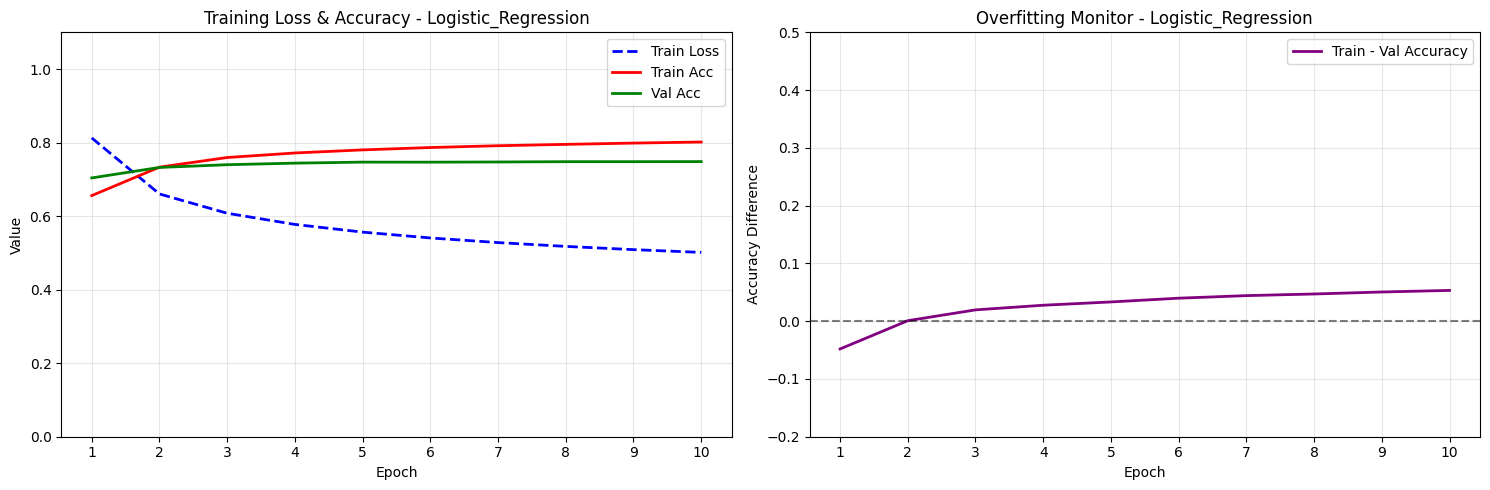


TRAINING SUMMARY
Model Name: Logistic_Regression
Final Train Loss: 0.5014
Final Train Accuracy: 0.8016
Final Val Loss: 0.6000
Final Val Accuracy: 0.7484
Best Val Accuracy: 0.7484 (Epoch 10)
Final Overfitting Gap: 0.0533


In [6]:
# 绘制训练曲线
plot_training_curves("Logistic_Regression", logreg_history)

# 打印训练摘要
print_training_summary("Logistic_Regression", logreg_history)

Testing: 100%|██████████| 53788/53788 [00:51<00:00, 1037.53it/s]



TEST RESULTS
Model Name: Logistic_Regression
Test Accuracy: 0.7493
Test Precision (weighted): 0.7405
Test Recall (weighted): 0.7493
Test F1 Score (weighted): 0.7425

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7735    0.7917    0.7825     18650
     Neutral     0.5820    0.4415    0.5021      9971
    Positive     0.7789    0.8398    0.8082     25167

    accuracy                         0.7493     53788
   macro avg     0.7115    0.6910    0.6976     53788
weighted avg     0.7405    0.7493    0.7425     53788



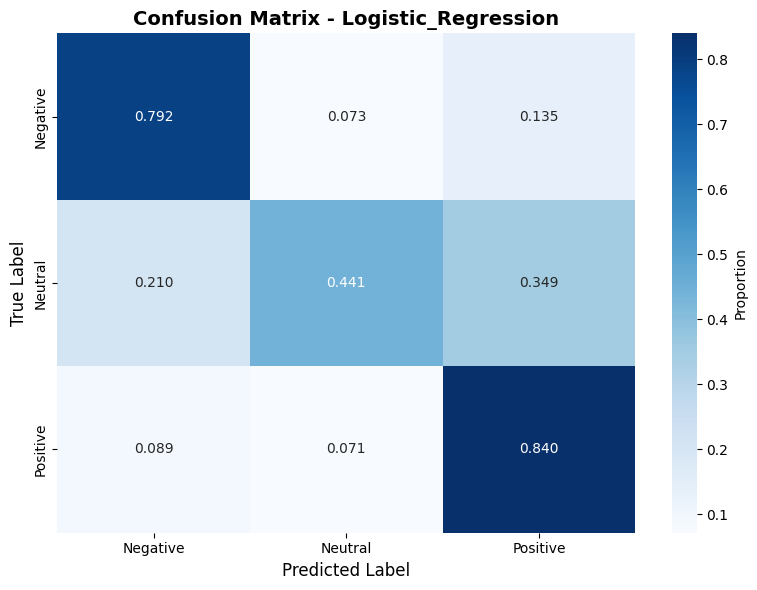


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7735, Recall=0.7917, F1=0.7825, Support=18650
 Neutral: Precision=0.5820, Recall=0.4415, F1=0.5021, Support=9971
Positive: Precision=0.7789, Recall=0.8398, F1=0.8082, Support=25167


In [7]:
test_results = test_model_comprehensive(
    model=logreg,
    model_name="Logistic_Regression",
    test_loader=test_data_loader_tfidf,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive']
)

### 多层感知机

In [8]:
# 构建数据集类和数据整理函数
class BowDataset(Dataset):  #@save
    def __init__(self, data: DataFrame) -> None:
        self.data = data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, i: int):
        return self.data.iloc[i]

def collate_fn_mlp(batch):  #@save
    # 从独立样本集合中构建各批次的输入输出
    # 其中 BowDataset 类定义了一个样本的数据结构，即输入标签和输出标签的元组
    # 因此，将输入 inputs 定义为一个张量的列表，其中每个张量为原始句子中词元序列对应的索引值序列
    inputs = [torch.tensor(b[0]) for b in batch]

    # 输出的目标 targets 为该批次中由全部样例输出结果构成的张量
    targets = torch.tensor([b[1] for b in batch], dtype=torch.long)

    # 获取一个批次中每个样例的序列长度
    offsets = [0] + [i.shape[0] for i in inputs]

    # 根据序列的长度，转换为每个序列起始位置的偏移量
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    # 将 inputs 列表中的张量拼接成一个大的张量
    inputs = torch.cat(inputs)

    return inputs, offsets, targets

In [9]:
from torch.nn import functional as F

class MLP(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class, 
                 pretrained_embedding_matrix=None):
        super(MLP, self).__init__()
        # EmbeddingBag 层
        self.embeddingbag = nn.EmbeddingBag(vocab_size, embedding_dim)

        # 词向量层：使用 EmbeddingBag
        if pretrained_embedding_matrix:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=False)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 线性变换：词向量层 -> 隐含层
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)

        # 使用ReLU激活函数
        self.activate = F.relu

        # 线性变换：激活层 -> 输出层
        self.linear2 = nn.Linear(hidden_dim, num_class)
        # self.dropout = nn.Dropout(dropout)
    
    def forward(self, inputs, offsets):
        # embeddings = self.embedding(inputs)  # (batch_size, seq_length, embed_size)
        # embedding = embeddings.mean(dim=1)  # (batch_size, embed_size)
        embedding = self.embeddingbag(inputs, offsets)
        hidden = self.activate(self.linear1(embedding))  # (batch_size, hidden_size)
        outputs = self.linear2(hidden)  # (batch_size, output_size)

        # 获得每个序列属于某个类别概率的对数值
        # probs = F.log_softmax(outputs, dim=1)
        return outputs



In [10]:
# 超参数设置
embedding_dim = 128
num_class = 3
hidden_dim = 256
batch_size = 32
num_epoch = 10

# 加载数据
train_dataset = BowDataset(train_idx)
val_dataset = BowDataset(val_idx)
test_dataset = BowDataset(test_idx)

train_data_loader_mlp = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=True)
val_data_loader_mlp = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=False)
test_data_loader_mlp = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_mlp, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp = MLP(len(vocab), embedding_dim, hidden_dim, num_class)
mlp.to(device)

MLP(
  (embeddingbag): EmbeddingBag(33152, 128, mode='mean')
  (embedding): Embedding(33152, 128)
  (linear1): Linear(in_features=128, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=3, bias=True)
)

In [11]:
# MLP 训练过程 - 使用通用框架
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

# 使用通用训练函数
history = train_model_with_validation(
    model=mlp,
    train_loader=train_data_loader_mlp,
    val_loader=val_data_loader_mlp,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device,
)

Training Epoch 1: 100%|██████████| 7155/7155 [00:24<00:00, 297.21it/s]


Epoch 1/10
    Train Loss: 0.7102	Train Accuracy: 0.6957
    Valid Loss: 0.6363	Valid Accuracy: 0.7328
    Valid Precision: 0.7143	Valid Recall: 0.7328	Valid F1: 0.7122
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7155/7155 [00:23<00:00, 304.99it/s]


Epoch 2/10
    Train Loss: 0.5819	Train Accuracy: 0.7584
    Valid Loss: 0.6122	Valid Accuracy: 0.7441
    Valid Precision: 0.7301	Valid Recall: 0.7441	Valid F1: 0.7304
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7155/7155 [00:23<00:00, 305.56it/s]


Epoch 3/10
    Train Loss: 0.5295	Train Accuracy: 0.7827
    Valid Loss: 0.6134	Valid Accuracy: 0.7433
    Valid Precision: 0.7337	Valid Recall: 0.7433	Valid F1: 0.7350
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7155/7155 [00:23<00:00, 303.95it/s]


Epoch 4/10
    Train Loss: 0.4881	Train Accuracy: 0.8015
    Valid Loss: 0.6328	Valid Accuracy: 0.7465
    Valid Precision: 0.7330	Valid Recall: 0.7465	Valid F1: 0.7325
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7155/7155 [00:23<00:00, 304.57it/s]


Epoch 5/10
    Train Loss: 0.4474	Train Accuracy: 0.8197
    Valid Loss: 0.6392	Valid Accuracy: 0.7439
    Valid Precision: 0.7331	Valid Recall: 0.7439	Valid F1: 0.7366
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 7155/7155 [00:23<00:00, 305.85it/s]


Epoch 6/10
    Train Loss: 0.4039	Train Accuracy: 0.8399
    Valid Loss: 0.6850	Valid Accuracy: 0.7409
    Valid Precision: 0.7320	Valid Recall: 0.7409	Valid F1: 0.7352
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 7155/7155 [00:23<00:00, 306.74it/s]


Epoch 7/10
    Train Loss: 0.3568	Train Accuracy: 0.8603
    Valid Loss: 0.7339	Valid Accuracy: 0.7371
    Valid Precision: 0.7271	Valid Recall: 0.7371	Valid F1: 0.7305
--------------------------------------------------------------------------------


Training Epoch 8: 100%|██████████| 7155/7155 [00:23<00:00, 300.67it/s]


Epoch 8/10
    Train Loss: 0.3094	Train Accuracy: 0.8826
    Valid Loss: 0.8186	Valid Accuracy: 0.7345
    Valid Precision: 0.7257	Valid Recall: 0.7345	Valid F1: 0.7292
--------------------------------------------------------------------------------


Training Epoch 9: 100%|██████████| 7155/7155 [00:25<00:00, 277.63it/s]


Epoch 9/10
    Train Loss: 0.2614	Train Accuracy: 0.9031
    Valid Loss: 0.9052	Valid Accuracy: 0.7236
    Valid Precision: 0.7185	Valid Recall: 0.7236	Valid F1: 0.7198
--------------------------------------------------------------------------------


Training Epoch 10: 100%|██████████| 7155/7155 [00:23<00:00, 303.03it/s]


Epoch 10/10
    Train Loss: 0.2164	Train Accuracy: 0.9223
    Valid Loss: 1.0209	Valid Accuracy: 0.7223
    Valid Precision: 0.7194	Valid Recall: 0.7223	Valid F1: 0.7208
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7541    0.7643    0.7592     17862
     Neutral     0.4470    0.4224    0.4344      8002
    Positive     0.7867    0.7935    0.7901     23165

    accuracy                         0.7223     49029
   macro avg     0.6626    0.6601    0.6612     49029
weighted avg     0.7194    0.7223    0.7208     49029



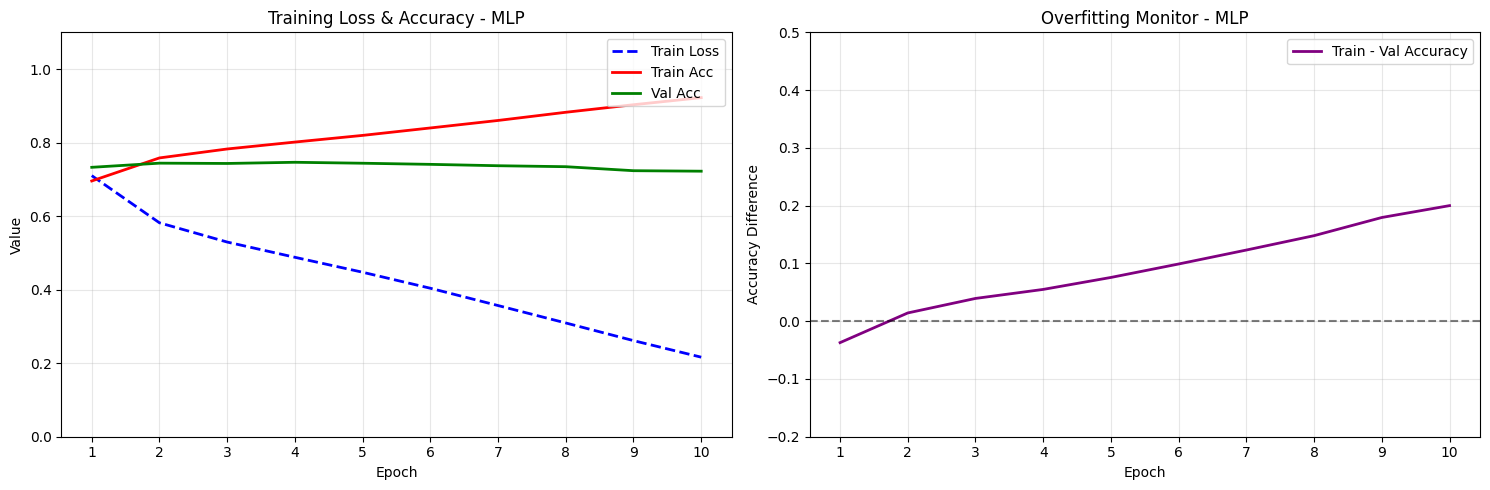


TRAINING SUMMARY
Model Name: MLP
Final Train Loss: 0.2164
Final Train Accuracy: 0.9223
Final Val Loss: 1.0209
Final Val Accuracy: 0.7223
Best Val Accuracy: 0.7465 (Epoch 4)
Final Overfitting Gap: 0.2000


In [12]:
# 绘制训练曲线
plot_training_curves("MLP", history)

# 打印训练摘要
print_training_summary("MLP", history)

Testing: 100%|██████████| 49057/49057 [00:37<00:00, 1315.70it/s]



TEST RESULTS
Model Name: MLP
Test Accuracy: 0.7230
Test Precision (weighted): 0.7192
Test Recall (weighted): 0.7230
Test F1 Score (weighted): 0.7210

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7574    0.7671    0.7622     17953
     Neutral     0.4496    0.4176    0.4330      8037
    Positive     0.7835    0.7951    0.7892     23067

    accuracy                         0.7230     49057
   macro avg     0.6635    0.6599    0.6615     49057
weighted avg     0.7192    0.7230    0.7210     49057



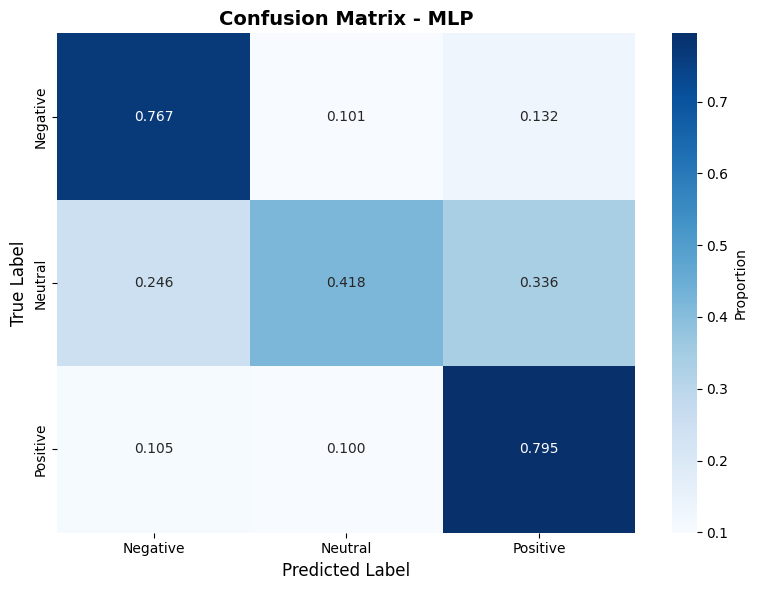


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7574, Recall=0.7671, F1=0.7622, Support=17953
 Neutral: Precision=0.4496, Recall=0.4176, F1=0.4330, Support=8037
Positive: Precision=0.7835, Recall=0.7951, F1=0.7892, Support=23067


In [13]:
# MLP 测试过程 - 使用通用框架
test_results = test_model_comprehensive(
    model=mlp,
    model_name="MLP",
    test_loader=test_data_loader_mlp,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive']
)

### 卷积神经网络

In [14]:
class CNN(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, filter_size, num_filter, num_class,
                 pretrained_embedding_matrix=None) -> None:
        super(CNN, self).__init__()
        if pretrained_embedding_matrix:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=False)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(embedding_dim, num_filter, filter_size, padding=1)  # padding=1 表示在卷积操作之前，将序列的前后各补充1个输入
        self.activate = F.relu
        self.linear = nn.Linear(num_filter, num_class)

    
    def forward(self, inputs):
        embedding = self.embedding(inputs)
        convolution = self.activate(self.conv1d(embedding.permute(0, 2, 1)))
        pooling = F.max_pool1d(convolution, kernel_size=convolution.shape[2])
        outputs = self.linear(pooling.squeeze(dim=2))
        return outputs

In [15]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_cnn(batch):
    inputs = [torch.tensor(b[0]) for b in batch]
    targets = torch.tensor([b[1] for b in batch], dtype=torch.long)

    # 对批次内的样本补齐，使其具有相同的长度
    inputs = pad_sequence(inputs, batch_first=True)
    return inputs, targets

In [16]:
train_data_loader_cnn = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=True)
test_data_loader_cnn = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_cnn, shuffle=False)

# CNN 相关参数
filter_size = 3
num_filter = 100

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = CNN(len(vocab), embedding_dim, filter_size, num_filter, num_class)
cnn.to(device)

CNN(
  (embedding): Embedding(33152, 128)
  (conv1d): Conv1d(128, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (linear): Linear(in_features=100, out_features=3, bias=True)
)

In [17]:
# CNN 训练过程 - 使用通用框架
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_cnn = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=False)

# 使用通用训练函数
cnn_history = train_model_with_validation(
    model=cnn,
    train_loader=train_data_loader_cnn,
    val_loader=val_data_loader_cnn,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 7155/7155 [00:25<00:00, 281.00it/s]


Epoch 1/10
    Train Loss: 0.7129	Train Accuracy: 0.6902
    Valid Loss: 0.6500	Valid Accuracy: 0.7253
    Valid Precision: 0.7117	Valid Recall: 0.7253	Valid F1: 0.7059
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7155/7155 [00:24<00:00, 292.29it/s]


Epoch 2/10
    Train Loss: 0.5755	Train Accuracy: 0.7598
    Valid Loss: 0.6337	Valid Accuracy: 0.7300
    Valid Precision: 0.7297	Valid Recall: 0.7300	Valid F1: 0.7250
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7155/7155 [00:24<00:00, 292.26it/s]


Epoch 3/10
    Train Loss: 0.5001	Train Accuracy: 0.7959
    Valid Loss: 0.6352	Valid Accuracy: 0.7489
    Valid Precision: 0.7337	Valid Recall: 0.7489	Valid F1: 0.7262
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7155/7155 [00:24<00:00, 291.27it/s]


Epoch 4/10
    Train Loss: 0.4296	Train Accuracy: 0.8290
    Valid Loss: 0.6704	Valid Accuracy: 0.7327
    Valid Precision: 0.7379	Valid Recall: 0.7327	Valid F1: 0.7331
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7155/7155 [00:24<00:00, 291.88it/s]


Epoch 5/10
    Train Loss: 0.3579	Train Accuracy: 0.8608
    Valid Loss: 0.7412	Valid Accuracy: 0.7302
    Valid Precision: 0.7404	Valid Recall: 0.7302	Valid F1: 0.7342
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 7155/7155 [00:25<00:00, 280.27it/s]


Epoch 6/10
    Train Loss: 0.2868	Train Accuracy: 0.8920
    Valid Loss: 0.8161	Valid Accuracy: 0.7276
    Valid Precision: 0.7301	Valid Recall: 0.7276	Valid F1: 0.7286
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 7155/7155 [00:26<00:00, 271.71it/s]


Epoch 7/10
    Train Loss: 0.2234	Train Accuracy: 0.9182
    Valid Loss: 0.9487	Valid Accuracy: 0.7262
    Valid Precision: 0.7228	Valid Recall: 0.7262	Valid F1: 0.7244
--------------------------------------------------------------------------------


Training Epoch 8: 100%|██████████| 7155/7155 [00:28<00:00, 251.32it/s]


Epoch 8/10
    Train Loss: 0.1731	Train Accuracy: 0.9382
    Valid Loss: 1.1011	Valid Accuracy: 0.7295
    Valid Precision: 0.7171	Valid Recall: 0.7295	Valid F1: 0.7215
--------------------------------------------------------------------------------


Training Epoch 9: 100%|██████████| 7155/7155 [00:27<00:00, 257.73it/s]


Epoch 9/10
    Train Loss: 0.1333	Train Accuracy: 0.9536
    Valid Loss: 1.2673	Valid Accuracy: 0.7182
    Valid Precision: 0.7151	Valid Recall: 0.7182	Valid F1: 0.7163
--------------------------------------------------------------------------------


Training Epoch 10: 100%|██████████| 7155/7155 [00:27<00:00, 264.95it/s]


Epoch 10/10
    Train Loss: 0.1033	Train Accuracy: 0.9645
    Valid Loss: 1.5038	Valid Accuracy: 0.7068
    Valid Precision: 0.7125	Valid Recall: 0.7068	Valid F1: 0.7058
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.8086    0.6650    0.7298     17862
     Neutral     0.4081    0.4198    0.4138      8002
    Positive     0.7436    0.8381    0.7881     23165

    accuracy                         0.7068     49029
   macro avg     0.6534    0.6410    0.6439     49029
weighted avg     0.7125    0.7068    0.7058     49029



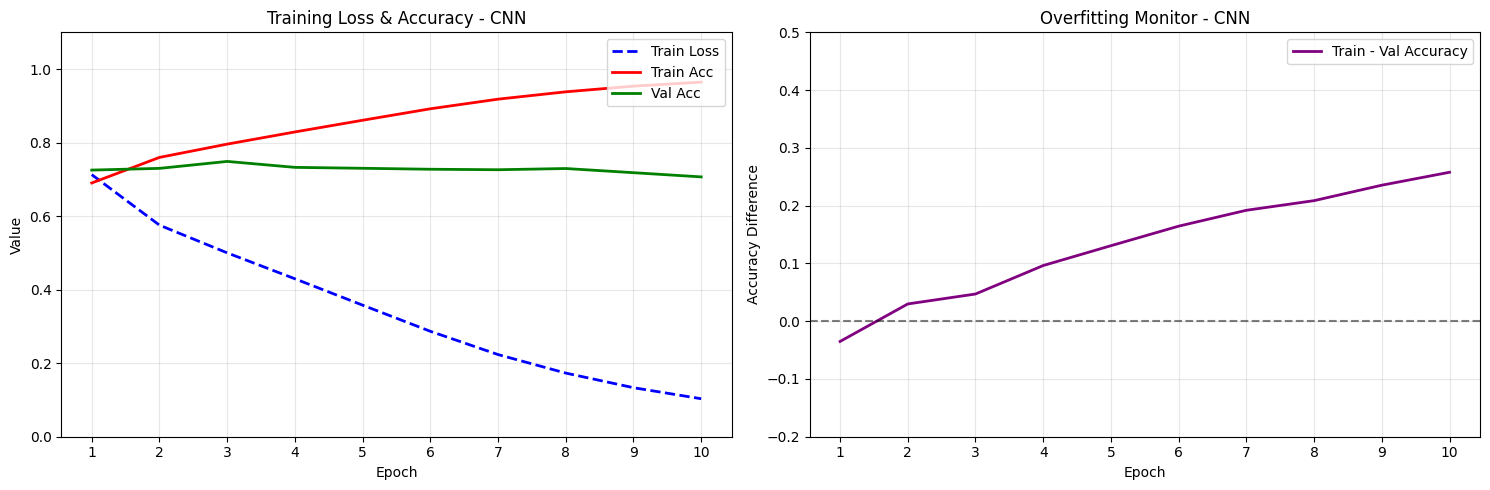


TRAINING SUMMARY
Model Name: CNN
Final Train Loss: 0.1033
Final Train Accuracy: 0.9645
Final Val Loss: 1.5038
Final Val Accuracy: 0.7068
Best Val Accuracy: 0.7489 (Epoch 3)
Final Overfitting Gap: 0.2578


In [18]:
# 绘制训练曲线
plot_training_curves("CNN", cnn_history)

# 打印训练摘要
print_training_summary("CNN", cnn_history)

Testing: 100%|██████████| 49057/49057 [00:50<00:00, 972.49it/s]



TEST RESULTS
Model Name: CNN
Test Accuracy: 0.7085
Test Precision (weighted): 0.7000
Test Recall (weighted): 0.7085
Test F1 Score (weighted): 0.7001

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7868    0.6934    0.7371     17953
     Neutral     0.4196    0.3294    0.3690      8037
    Positive     0.7302    0.8524    0.7866     23067

    accuracy                         0.7085     49057
   macro avg     0.6455    0.6250    0.6309     49057
weighted avg     0.7000    0.7085    0.7001     49057



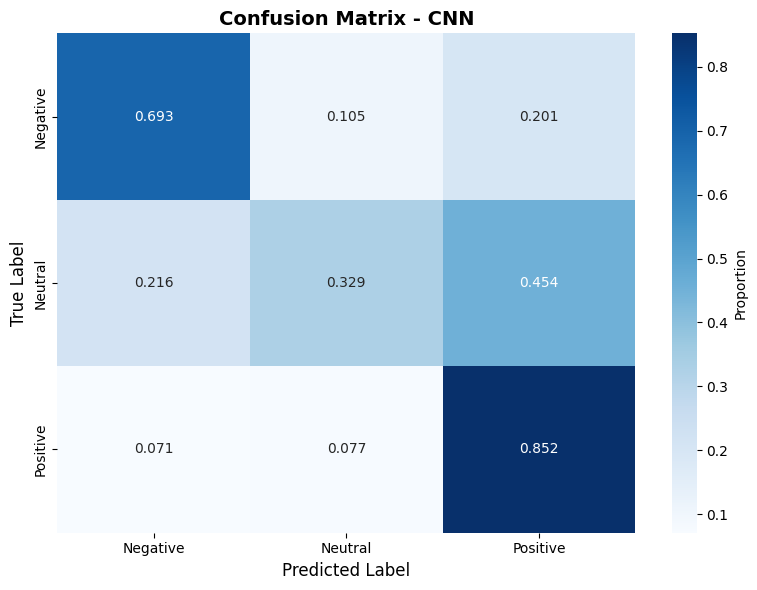


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7868, Recall=0.6934, F1=0.7371, Support=17953
 Neutral: Precision=0.4196, Recall=0.3294, F1=0.3690, Support=8037
Positive: Precision=0.7302, Recall=0.8524, F1=0.7866, Support=23067


In [19]:
# CNN 测试过程 - 使用通用框架
cnn_test_results = test_model_comprehensive(
    model=cnn,
    model_name="CNN",
    test_loader=test_data_loader_cnn,
    device=device
)

### 长短时记忆网络

In [20]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_lstm(batch):  #@save
    lengths = torch.tensor([len(b[0]) for b in batch], dtype=torch.long)
    inputs = [torch.tensor(b[0]) for b in batch]
    targets = torch.tensor([b[1] for b in batch], dtype=torch.long)

    # 使用 pad_sequence 函数对输入序列进行填充
    inputs = pad_sequence(inputs, batch_first=True)

    return inputs, lengths, targets

In [21]:
from torch.nn.utils.rnn import pack_padded_sequence

class LSTM(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class, 
                 pretrained_embedding_matrix=None):
        super(LSTM, self).__init__()
        if pretrained_embedding_matrix:
            self.embeddings = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=False)
        else:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.output = nn.Linear(hidden_dim, num_class)

    def forward(self, inputs, lengths):
        embedding = self.embeddings(inputs)

        # 使用 pack_padded_sequence 函数对嵌入序列进行打包
        x_pack = pack_padded_sequence(embedding, lengths, batch_first=True, enforce_sorted=False)
        hidden, (hn, cn) = self.lstm(x_pack)
        outputs = self.output(hn[-1])
        return outputs

In [22]:
train_data_loader_lstm = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=True)
test_data_loader_lstm = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_lstm, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm = LSTM(len(vocab), embedding_dim, hidden_dim, num_class)
lstm.to(device)

LSTM(
  (embeddings): Embedding(33152, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (output): Linear(in_features=256, out_features=3, bias=True)
)

In [23]:
# LSTM 训练过程 - 使用通用框架
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_lstm = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=False)

# 使用通用训练函数
lstm_history = train_model_with_validation(
    model=lstm,
    train_loader=train_data_loader_lstm,
    val_loader=val_data_loader_lstm,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 7155/7155 [00:37<00:00, 189.16it/s]


Epoch 1/10
    Train Loss: 0.6811	Train Accuracy: 0.7068
    Valid Loss: 0.6034	Valid Accuracy: 0.7420
    Valid Precision: 0.7284	Valid Recall: 0.7420	Valid F1: 0.7321
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7155/7155 [00:35<00:00, 199.92it/s]


Epoch 2/10
    Train Loss: 0.5256	Train Accuracy: 0.7816
    Valid Loss: 0.5762	Valid Accuracy: 0.7566
    Valid Precision: 0.7450	Valid Recall: 0.7566	Valid F1: 0.7487
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7155/7155 [00:36<00:00, 197.26it/s]


Epoch 3/10
    Train Loss: 0.4183	Train Accuracy: 0.8304
    Valid Loss: 0.6042	Valid Accuracy: 0.7540
    Valid Precision: 0.7523	Valid Recall: 0.7540	Valid F1: 0.7531
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7155/7155 [00:37<00:00, 189.73it/s]


Epoch 4/10
    Train Loss: 0.3045	Train Accuracy: 0.8812
    Valid Loss: 0.7101	Valid Accuracy: 0.7540
    Valid Precision: 0.7426	Valid Recall: 0.7540	Valid F1: 0.7463
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7155/7155 [00:37<00:00, 192.02it/s]


Epoch 5/10
    Train Loss: 0.2003	Train Accuracy: 0.9245
    Valid Loss: 0.8500	Valid Accuracy: 0.7450
    Valid Precision: 0.7381	Valid Recall: 0.7450	Valid F1: 0.7409
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 7155/7155 [00:36<00:00, 194.73it/s]


Epoch 6/10
    Train Loss: 0.1292	Train Accuracy: 0.9538
    Valid Loss: 1.0251	Valid Accuracy: 0.7427
    Valid Precision: 0.7385	Valid Recall: 0.7427	Valid F1: 0.7404
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 7155/7155 [00:36<00:00, 195.19it/s]


Epoch 7/10
    Train Loss: 0.0918	Train Accuracy: 0.9678
    Valid Loss: 1.1732	Valid Accuracy: 0.7346
    Valid Precision: 0.7350	Valid Recall: 0.7346	Valid F1: 0.7347
--------------------------------------------------------------------------------


Training Epoch 8: 100%|██████████| 7155/7155 [00:37<00:00, 192.43it/s]


Epoch 8/10
    Train Loss: 0.0748	Train Accuracy: 0.9738
    Valid Loss: 1.2881	Valid Accuracy: 0.7377
    Valid Precision: 0.7337	Valid Recall: 0.7377	Valid F1: 0.7355
--------------------------------------------------------------------------------


Training Epoch 9: 100%|██████████| 7155/7155 [00:37<00:00, 190.56it/s]


Epoch 9/10
    Train Loss: 0.0669	Train Accuracy: 0.9770
    Valid Loss: 1.3430	Valid Accuracy: 0.7359
    Valid Precision: 0.7345	Valid Recall: 0.7359	Valid F1: 0.7352
--------------------------------------------------------------------------------


Training Epoch 10: 100%|██████████| 7155/7155 [00:36<00:00, 193.70it/s]


Epoch 10/10
    Train Loss: 0.0612	Train Accuracy: 0.9787
    Valid Loss: 1.4173	Valid Accuracy: 0.7343
    Valid Precision: 0.7345	Valid Recall: 0.7343	Valid F1: 0.7343
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7711    0.7889    0.7799     17862
     Neutral     0.4396    0.4393    0.4394      8002
    Positive     0.8083    0.7941    0.8011     23165

    accuracy                         0.7343     49029
   macro avg     0.6730    0.6741    0.6735     49029
weighted avg     0.7345    0.7343    0.7343     49029



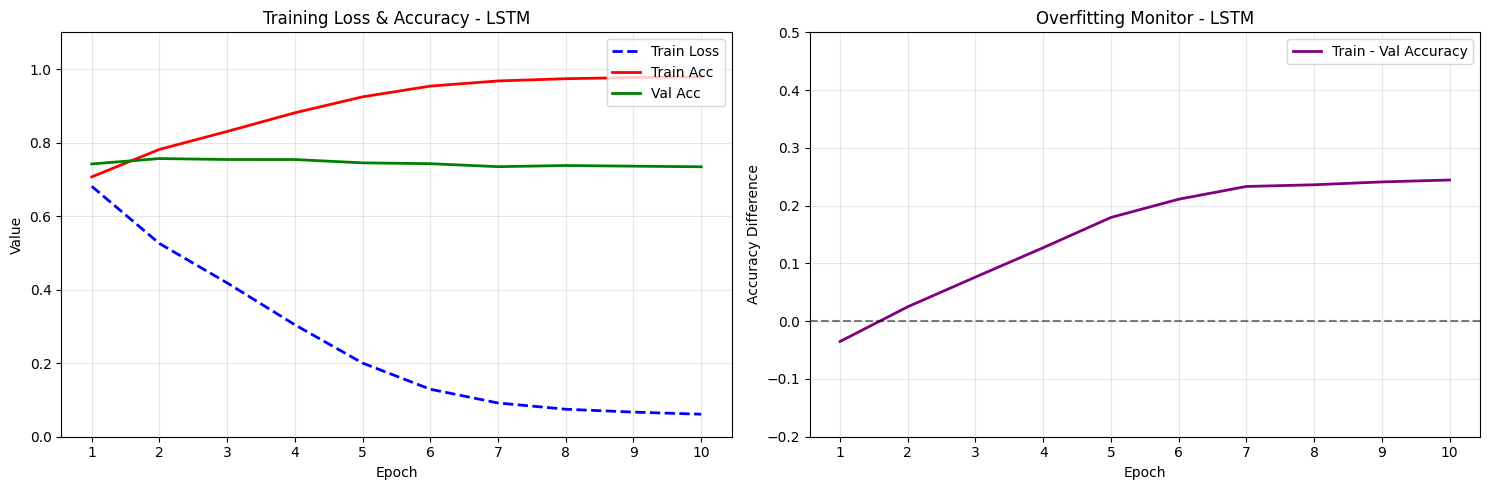


TRAINING SUMMARY
Model Name: LSTM
Final Train Loss: 0.0612
Final Train Accuracy: 0.9787
Final Val Loss: 1.4173
Final Val Accuracy: 0.7343
Best Val Accuracy: 0.7566 (Epoch 2)
Final Overfitting Gap: 0.2444


In [24]:
# 绘制训练曲线
plot_training_curves("LSTM", lstm_history)

# 打印训练摘要
print_training_summary("LSTM", lstm_history)

Testing: 100%|██████████| 49057/49057 [01:17<00:00, 630.12it/s]



TEST RESULTS
Model Name: LSTM
Test Accuracy: 0.7369
Test Precision (weighted): 0.7360
Test Recall (weighted): 0.7369
Test F1 Score (weighted): 0.7364

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7769    0.7898    0.7833     17953
     Neutral     0.4460    0.4380    0.4420      8037
    Positive     0.8051    0.7998    0.8024     23067

    accuracy                         0.7369     49057
   macro avg     0.6760    0.6759    0.6759     49057
weighted avg     0.7360    0.7369    0.7364     49057



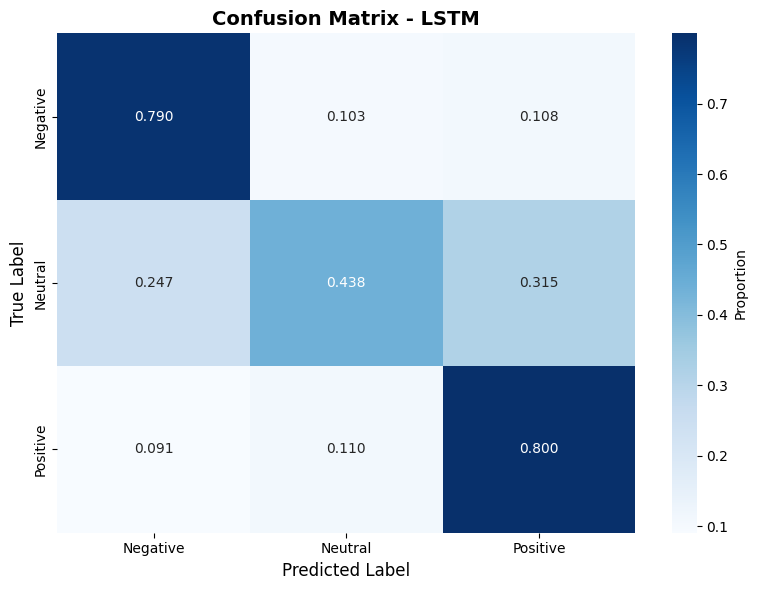


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7769, Recall=0.7898, F1=0.7833, Support=17953
 Neutral: Precision=0.4460, Recall=0.4380, F1=0.4420, Support=8037
Positive: Precision=0.8051, Recall=0.7998, F1=0.8024, Support=23067


In [25]:
# LSTM 测试过程 - 使用通用框架
lstm_test_results = test_model_comprehensive(
    model=lstm,
    model_name="LSTM", 
    test_loader=test_data_loader_lstm,
    device=device
)

### Transformer

In [26]:
def length_to_mask(lengths):  #@save
    max_len = torch.max(lengths)
    mask = torch.arange(max_len, device=lengths.device).expand(lengths.shape[0], max_len) < lengths.unsqueeze(1)
    return mask

In [27]:
import math

class PositionalEncoding(nn.Module):  #@save
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)) / d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

In [28]:
class Transformer(nn.Module):  #@save
    def __init__(
            self, 
            vocab_size, 
            embedding_dim, 
            num_class, 
            dim_feedforward=512, 
            num_head=2, 
            num_layers=2, 
            dropout=0.1, 
            max_len=128, 
            activation: str = "relu", 
            pretrained_embedding_matrix=None
            ):
        super(Transformer, self).__init__()
        self.embedding_dim = embedding_dim
        if pretrained_embedding_matrix:
            self.embeddings = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=False)
        else:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = PositionalEncoding(embedding_dim, dropout, max_len)  # 位置编码

        encoder_layer = nn.TransformerEncoderLayer(embedding_dim, num_head, dim_feedforward, dropout, activation)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        self.output = nn.Linear(embedding_dim, num_class)

    def forward(self, inputs, lengths):
        inputs = torch.transpose(inputs, 0, 1)

        hidden_states = self.embeddings(inputs)
        hidden_states = self.position_embedding(hidden_states)

        lengths = lengths.to(inputs.device)
        attention_mask = length_to_mask(lengths) == False

        # 根据批次中每个序列长度生成 Mask 矩阵
        hidden_states = self.transformer(hidden_states, src_key_padding_mask=attention_mask)
        hidden_states = hidden_states[0, :, :]

        # 去第一个词元的输出结果作为分类层的输入
        outputs = self.output(hidden_states)
        return outputs

In [29]:
collate_fn_trans = collate_fn_lstm  #@save

In [30]:
train_data_loader_trans = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=True)
test_data_loader_trans = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_trans, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer = Transformer(len(vocab), embedding_dim, num_class)
transformer.to(device)

e:\anaconda3\envs\nlpllma\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer(
  (embeddings): Embedding(33152, 128)
  (position_embedding): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output): Linear(in_features=128, out_features=3, bias=True)
)

In [31]:
# Transformer 训练过程 - 使用通用框架
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_trans = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=False)

# 使用通用训练函数
transformer_history = train_model_with_validation(
    model=transformer,
    train_loader=train_data_loader_trans,
    val_loader=val_data_loader_trans,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 7155/7155 [00:49<00:00, 144.67it/s]


Epoch 1/10
    Train Loss: 0.7767	Train Accuracy: 0.6620
    Valid Loss: 0.6758	Valid Accuracy: 0.7108
    Valid Precision: 0.6856	Valid Recall: 0.7108	Valid F1: 0.6797
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7155/7155 [00:48<00:00, 148.19it/s]


Epoch 2/10
    Train Loss: 0.6443	Train Accuracy: 0.7298
    Valid Loss: 0.6370	Valid Accuracy: 0.7335
    Valid Precision: 0.7165	Valid Recall: 0.7335	Valid F1: 0.7079
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7155/7155 [00:47<00:00, 150.93it/s]


Epoch 3/10
    Train Loss: 0.5876	Train Accuracy: 0.7571
    Valid Loss: 0.6278	Valid Accuracy: 0.7408
    Valid Precision: 0.7259	Valid Recall: 0.7408	Valid F1: 0.7285
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7155/7155 [00:46<00:00, 155.50it/s]


Epoch 4/10
    Train Loss: 0.5473	Train Accuracy: 0.7759
    Valid Loss: 0.6238	Valid Accuracy: 0.7388
    Valid Precision: 0.7255	Valid Recall: 0.7388	Valid F1: 0.7289
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7155/7155 [00:43<00:00, 164.50it/s]


Epoch 5/10
    Train Loss: 0.5167	Train Accuracy: 0.7899
    Valid Loss: 0.6558	Valid Accuracy: 0.7368
    Valid Precision: 0.7290	Valid Recall: 0.7368	Valid F1: 0.7314
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 7155/7155 [00:43<00:00, 164.29it/s]


Epoch 6/10
    Train Loss: 0.4883	Train Accuracy: 0.8021
    Valid Loss: 0.6425	Valid Accuracy: 0.7391
    Valid Precision: 0.7282	Valid Recall: 0.7391	Valid F1: 0.7318
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 7155/7155 [00:43<00:00, 162.70it/s]


Epoch 7/10
    Train Loss: 0.4647	Train Accuracy: 0.8138
    Valid Loss: 0.6743	Valid Accuracy: 0.7354
    Valid Precision: 0.7282	Valid Recall: 0.7354	Valid F1: 0.7305
--------------------------------------------------------------------------------


Training Epoch 8: 100%|██████████| 7155/7155 [00:44<00:00, 159.79it/s]


Epoch 8/10
    Train Loss: 0.4452	Train Accuracy: 0.8223
    Valid Loss: 0.6809	Valid Accuracy: 0.7332
    Valid Precision: 0.7312	Valid Recall: 0.7332	Valid F1: 0.7310
--------------------------------------------------------------------------------


Training Epoch 9: 100%|██████████| 7155/7155 [00:43<00:00, 164.93it/s]


Epoch 9/10
    Train Loss: 0.4266	Train Accuracy: 0.8317
    Valid Loss: 0.6892	Valid Accuracy: 0.7390
    Valid Precision: 0.7278	Valid Recall: 0.7390	Valid F1: 0.7295
--------------------------------------------------------------------------------


Training Epoch 10: 100%|██████████| 7155/7155 [00:43<00:00, 164.90it/s]


Epoch 10/10
    Train Loss: 0.4099	Train Accuracy: 0.8386
    Valid Loss: 0.7090	Valid Accuracy: 0.7359
    Valid Precision: 0.7313	Valid Recall: 0.7359	Valid F1: 0.7332
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7578    0.7950    0.7759     17862
     Neutral     0.4711    0.4236    0.4461      8002
    Positive     0.8008    0.7982    0.7995     23165

    accuracy                         0.7359     49029
   macro avg     0.6765    0.6723    0.6738     49029
weighted avg     0.7313    0.7359    0.7332     49029



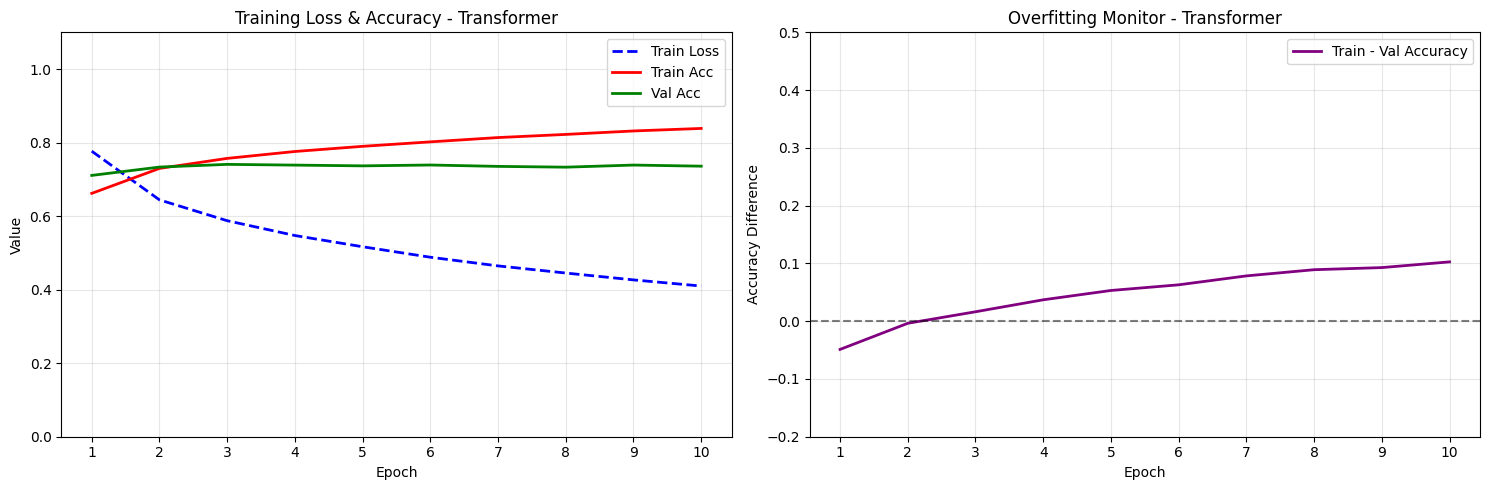


TRAINING SUMMARY
Model Name: Transformer
Final Train Loss: 0.4099
Final Train Accuracy: 0.8386
Final Val Loss: 0.7090
Final Val Accuracy: 0.7359
Best Val Accuracy: 0.7408 (Epoch 3)
Final Overfitting Gap: 0.1027


In [32]:
# 绘制训练曲线
plot_training_curves("Transformer", transformer_history)

# 打印训练摘要
print_training_summary("Transformer", transformer_history)

Testing: 100%|██████████| 49057/49057 [01:39<00:00, 493.23it/s]



TEST RESULTS
Model Name: Transformer
Test Accuracy: 0.7388
Test Precision (weighted): 0.7339
Test Recall (weighted): 0.7388
Test F1 Score (weighted): 0.7359

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7597    0.8018    0.7802     17953
     Neutral     0.4752    0.4242    0.4482      8037
    Positive     0.8040    0.7994    0.8017     23067

    accuracy                         0.7388     49057
   macro avg     0.6796    0.6751    0.6767     49057
weighted avg     0.7339    0.7388    0.7359     49057



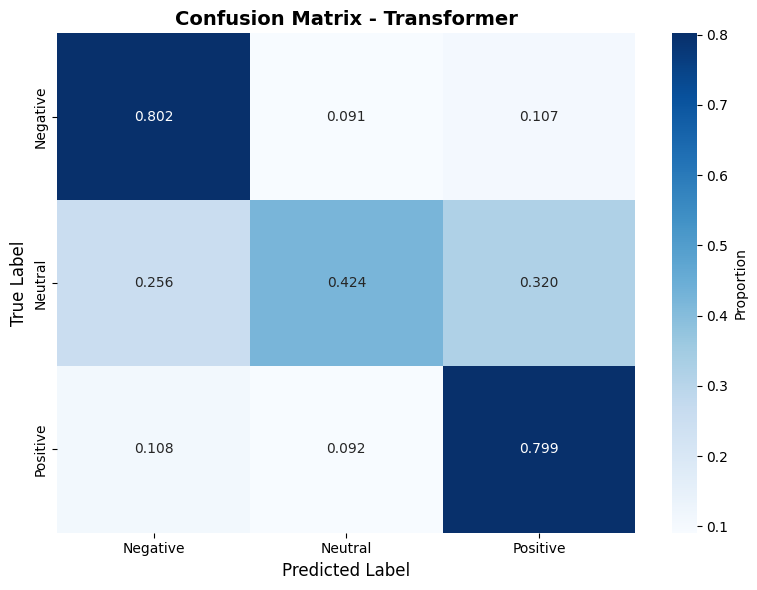


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7597, Recall=0.8018, F1=0.7802, Support=17953
 Neutral: Precision=0.4752, Recall=0.4242, F1=0.4482, Support=8037
Positive: Precision=0.8040, Recall=0.7994, F1=0.8017, Support=23067


In [33]:
# Transformer 测试过程 - 使用通用框架
transformer_test_results = test_model_comprehensive(
    model=transformer,
    model_name="Transformer",
    test_loader=test_data_loader_trans,
    device=device
)


MODEL PERFORMANCE COMPARISON
      Model  Accuracy  Precision  Recall  F1 Score
        MLP    0.7230     0.7192  0.7230    0.7210
        CNN    0.7085     0.7000  0.7085    0.7001
       LSTM    0.7369     0.7360  0.7369    0.7364
Transformer    0.7388     0.7339  0.7388    0.7359


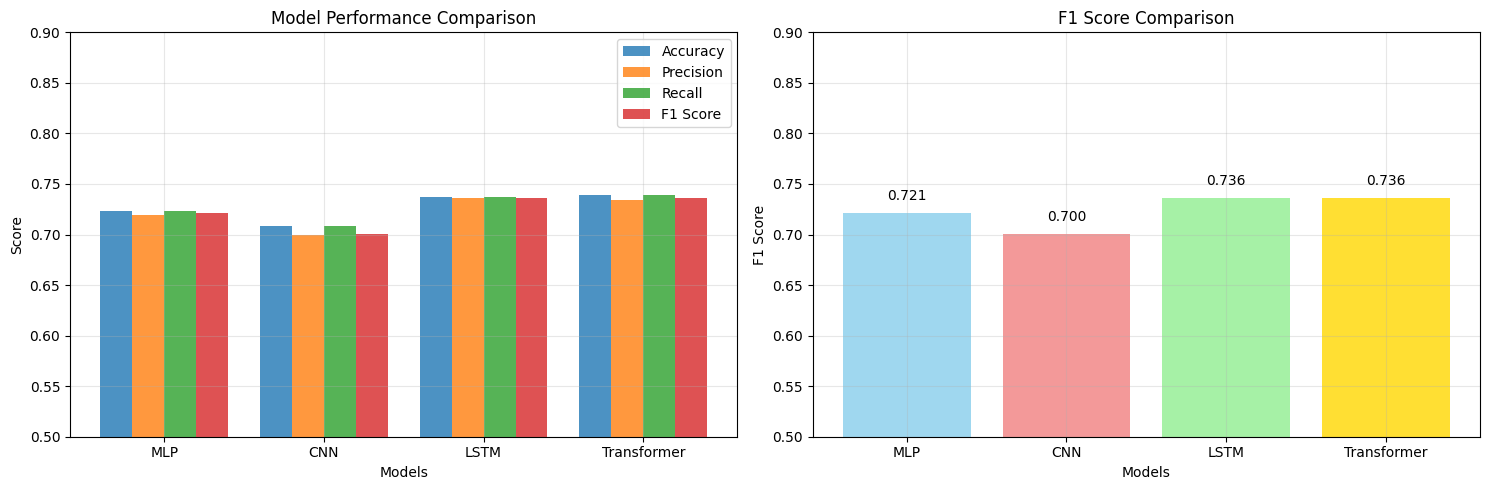


Best performing model: LSTM (F1 Score: 0.7364)


In [34]:
# 模型性能比较
def compare_models(model_results, model_names=None):
    """
    比较多个模型的性能
    
    Args:
        model_results: 模型结果字典的列表
        model_names: 模型名称列表
    """
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(model_results))]
    
    # 创建比较表格
    import pandas as pd
    
    comparison_data = []
    for i, (name, result) in enumerate(zip(model_names, model_results)):
        comparison_data.append({
            'Model': name,
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1 Score': result['f1']
        })
    
    df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    print(df.round(4).to_string(index=False))
    
    # 绘制比较图表
    plt.figure(figsize=(15, 5))
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metric_keys = ['accuracy', 'precision', 'recall', 'f1']  # 对应的字典键
    x = np.arange(len(model_names))
    width = 0.2
    
    plt.subplot(1, 2, 1)
    for i, (metric, key) in enumerate(zip(metrics, metric_keys)):
        values = [result[key] for result in model_results]
        plt.bar(x + i*width, values, width, label=metric, alpha=0.8)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width*1.5, model_names)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 0.9)
    
    # F1分数单独比较
    plt.subplot(1, 2, 2)
    f1_scores = [result['f1'] for result in model_results]
    bars = plt.bar(model_names, f1_scores, alpha=0.8, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'][:len(model_names)])
    plt.xlabel('Models')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Comparison')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 0.9)
    
    # 在柱状图上显示数值
    for bar, score in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # 找出最佳模型
    best_idx = np.argmax([result['f1'] for result in model_results])
    print(f"\nBest performing model: {model_names[best_idx]} (F1 Score: {model_results[best_idx]['f1']:.4f})")

# 使用示例（在所有模型都训练完成后运行）
model_results = [
    test_results,  # MLP
    cnn_test_results,  # CNN  
    lstm_test_results,  # LSTM
    transformer_test_results  # Transformer
]
model_names = ['MLP', 'CNN', 'LSTM', 'Transformer']
compare_models(model_results, model_names)